## Neural Networks
### Lab session 4: Graph neural networks (with [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/))

In [111]:
# Note: The version should match the one we used to install PyTorch Geometric (PyG)
import torch
import torch.nn.functional as F
print(torch.__version__)

2.0.1+cu117


In [112]:
import torch_geometric as pygeom
import pytorch_lightning as pylight

In [113]:
from torchmetrics.functional import accuracy

### Part 1: Loading the dataset

In [228]:
dataset = pygeom.datasets.ExplainerDataset(
    graph_generator=pygeom.datasets.graph_generator.BAGraph(num_nodes=300, num_edges=5),
    motif_generator='house',
    num_motifs=80,
)

In [229]:
import networkx as nx
import matplotlib.colors as mcolors

In [230]:
g = dataset[0]

In [233]:
g

Explanation(edge_index=[2, 3952], y=[700], edge_mask=[3952], node_mask=[700])

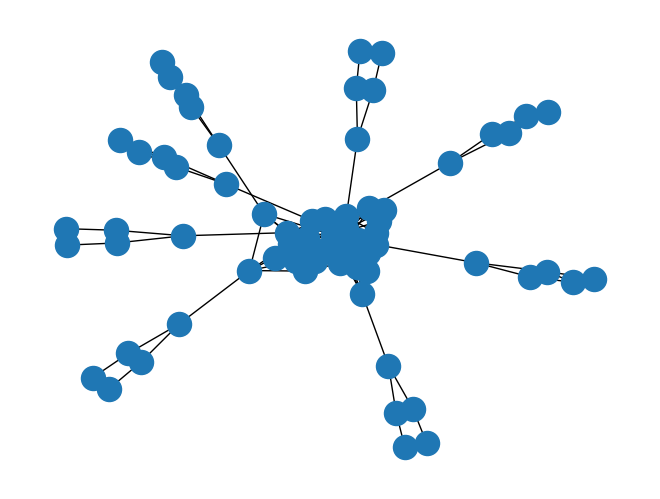

In [227]:

colors = list(mcolors.TABLEAU_COLORS)
nx.draw(pygeom.utils.to_networkx(g, to_undirected=True),
        node_color=colors[0])

In [210]:
dataset[0]

Data(x=[700, 10], edge_index=[2, 3960], y=[700], expl_mask=[700], edge_label=[3960])

In [114]:
# The dataset is a graph classification dataset, where each graph corresponds to
# a molecule: https://paperswithcode.com/dataset/mutag
# "cleaned" removes isomorphic (non-distinguishable) graphs
dataset = pygeom.datasets.TUDataset('./mutag', 'MUTAG', cleaned=True)

In [115]:
len(dataset)

135

In [116]:
# Because each graph dataset has its own characteristics (e.g., node features, edge
# feautures), PyG does not make any assumptions on what is inside each graph. This
# must be checked dataset-by-dataset.
g = dataset[0]

In [117]:
# Node feature matrix (nodes, features)
g.x.shape

torch.Size([17, 7])

In [118]:
# Each node has a one-hot encoding of its type.
g.x[0]
# If you are curious, this is the map: 
ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F', 'Br']

<BarContainer object of 7 artists>

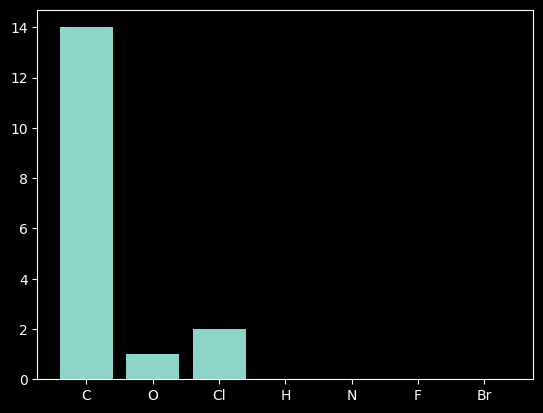

In [119]:
# Check the distribution of atoms
import matplotlib.pyplot as plt
plt.bar(ATOM_MAP, g.x.sum(0))

In [120]:
# Each graph has a binary label
g.y

tensor([1])

In [121]:
# The adjacency matrix is stored as a (2, e) tensor, where e is the numbed of edges.
g.edge_index.shape

torch.Size([2, 38])

In [122]:
g.edge_index.T[0:10]

tensor([[0, 1],
        [0, 5],
        [1, 0],
        [1, 2],
        [2, 1],
        [2, 3],
        [3, 2],
        [3, 4],
        [3, 9],
        [4, 3]])

In [123]:
# The adjacency is undirected, i.e., if (i, j) is present in edge_index, (j, i) is also present.
pygeom.utils.is_undirected(g.edge_index)

True

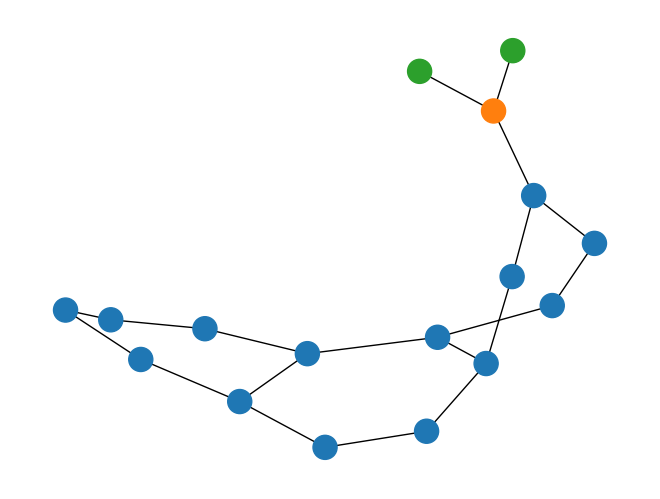

In [124]:
# We can use NetworkX to draw the graph
import networkx as nx
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS)
nx.draw(pygeom.utils.to_networkx(g, to_undirected=True),
        node_color=[colors[i.item()] for i in g.x.argmax(dim=1)])

### Part 2: Transformations

In [125]:
# PyG has a set of transforms customized for graph-based data:
# https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html
# For example, we can transform the adjacency matrix to a sparse matrix:
g = pygeom.transforms.ToSparseTensor()(g)
print(g.adj_t)

tensor(crow_indices=tensor([ 0,  2,  4,  6,  9, 12, 14, 16, 18, 21, 24, 26, 28,
                            31, 33, 36, 37, 38]),
       col_indices=tensor([ 1,  5,  0,  2,  1,  3,  2,  4,  9,  3,  5,  6,  0,
                            4,  4,  7,  6,  8,  7,  9, 13,  3,  8, 10,  9, 11,
                           10, 12, 11, 13, 14,  8, 12, 12, 15, 16, 14, 14]),
       values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), size=(17, 17),
       nnz=38, layout=torch.sparse_csr)


In [126]:
# As in torchvision, we can compose multiple transforms when loading
trans = pygeom.transforms.Compose([
    pygeom.transforms.OneHotDegree(10),
])

In [127]:
dataset = pygeom.datasets.TUDataset('./mutag', 'MUTAG', cleaned=True, transform=trans)

In [128]:
g = dataset[0]

In [129]:
# The new features are a one-hot encoding of the degree
g.x.shape

torch.Size([17, 18])

In [130]:
# Simple train-test split
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(range(len(dataset)), stratify = torch.Tensor([g.y for g in dataset]))

In [131]:
train_dataset = dataset[train_idx]
test_dataset = dataset[test_idx]

### Part 3: Mini-batching for graphs

In [132]:
# PyG has a lot of additional data loaders to perform, e.g., sampling of a subgraph
# from a larger graph: https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html
train_loader = pygeom.loader.DataLoader(train_dataset, batch_size=8, shuffle=True)

In [133]:
for batch in train_loader:
  break

In [134]:
# Node features of all the graphs in the mini-batch
batch.x.shape

torch.Size([145, 18])

In [135]:
# One label for each graph in the mini-batch
batch.y.shape

torch.Size([8])

In [136]:
# This corresponds to a block-diagonal adjacency matrix (8 blocks, one for each graph)
batch.edge_index.shape

torch.Size([2, 320])

In [137]:
# batch.batch[i] = j means that node i belongs to graph j
batch.batch.shape

torch.Size([145])

In [138]:
batch.batch[0:50]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2])

### Part 4: Model building

In [139]:
# Check out the cheatsheet for a list of possible layers implemented in PyG:
# https://pytorch-geometric.readthedocs.io/en/latest/notes/cheatsheet.html
gcnconv = pygeom.nn.GCNConv(18, 32)

In [140]:
# Note: same trainable parameters as a Linear layer with the same hyper-parameters.
for p in gcnconv.parameters():
  print(p.shape)

torch.Size([32])
torch.Size([32, 18])


In [141]:
gcnconv(batch.x, batch.edge_index).shape

torch.Size([145, 32])

In [142]:
# If you do not know PyTorch Lightning, read the 15-minutes intro here:
# https://pytorch-lightning.readthedocs.io/en/stable/starter/introduction.html

In [158]:
class SimpleGNN(pylight.LightningModule):
  # Simple GNN with 2 GC layers, graph pooling, and a dense layer at the end.

  def __init__(self):
    super().__init__()
    self.gc1 = pygeom.nn.GCNConv(18, 64)
    self.gc2 = pygeom.nn.GCNConv(64, 64)
    self.dense = torch.nn.Linear(64, 1)

  def forward(self, x, edge_index, batch):
    # Note how each layer has its own requirements in terms of inputs, e.g.,
    # for graph pooling we need the batch tensor, for GCNConv we need the
    # adjacency matrix.
    out = F.relu(self.gc1(x, edge_index))  # (nodes, 64)
    out = F.relu(self.gc2(out, edge_index))      # (nodes, 64)
    out = pygeom.nn.global_mean_pool(out, batch) # (graphs, 64)
    return self.dense(out)

  # From here below, it's PyTorch Lightning code

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters())

  def training_step(self, batch, _):
    y_pred = self(batch.x, batch.edge_index, batch.batch)
    loss = F.binary_cross_entropy_with_logits(y_pred, batch.y.unsqueeze(1).float())
    self.log('train_loss', loss, prog_bar=True, batch_size=8)
    return loss

  def validation_step(self, batch, _):
    y_hat = self.forward(batch.x, batch.edge_index, batch.batch)
    self.log("val_accuracy", accuracy(y_hat, batch.y.unsqueeze(1), task='binary'), prog_bar=True, batch_size=8)
    self.log('val_loss', F.binary_cross_entropy_with_logits(y_hat, batch.y.unsqueeze(1).float()), prog_bar=True, batch_size=8)

In [159]:
gcn = SimpleGNN()

In [160]:
gcn(batch.x, batch.edge_index, batch.batch).shape

torch.Size([8, 1])

### Part 5: Training the model

In [161]:
# We can use callbacks to add additional functionalities during training:
# https://pytorch-lightning.readthedocs.io/en/stable/api_references.html#callbacks

In [162]:
# Let us experiment with some early stopping
es_callback = pylight.callbacks.EarlyStopping('val_loss', patience=5, mode='min')

In [163]:

trainer = pylight.Trainer(max_epochs=100, callbacks=[es_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [164]:
# We also initialize the validation loader
val_loader = pygeom.loader.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [165]:
trainer.fit(gcn, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | gc1   | GCNConv | 1.2 K 
1 | gc2   | GCNConv | 4.2 K 
2 | dense | Linear  | 65    
----------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)


/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of trainin

Epoch 88: 100%|██████████| 13/13 [00:00<00:00, 57.38it/s, v_num=5, train_loss=0.301, val_accuracy=0.900, val_loss=0.324] 


<Axes: xlabel='epoch'>

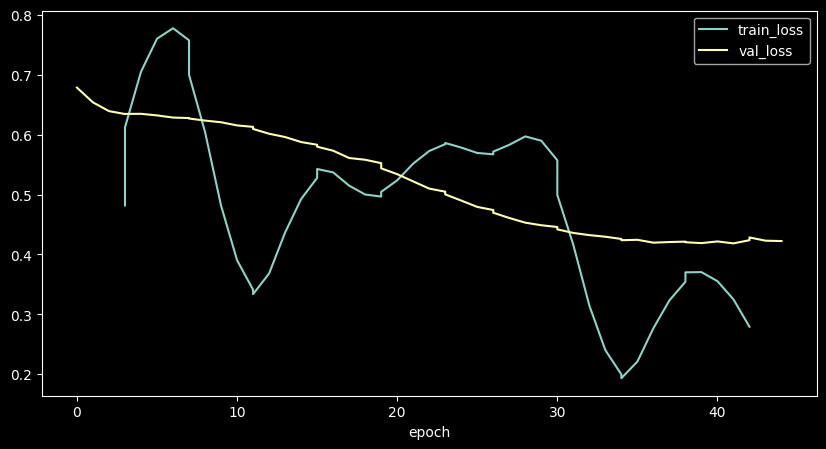

In [201]:
# graph of train and validation loss from csv
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('lightning_logs/version_3/metrics.csv')
df.interpolate('quadratic').plot(x='epoch', y=['train_loss', 'val_loss'], figsize=(10, 5))
